# Using a Random Forest and SVM for breast cancer detection in images

### The data was obtained from the University of California, Irvine’s Machine Learning Repository (Dua and Graff, 2019).

In [ ]:
""" This section imports all the required libraries """
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, \
                                classification_report, confusion_matrix
import pandas as pd
import seaborn as sns; sns.set()
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
plotly.tools.set_credentials_file(username='username', api_key='api_key')

# Data Extraction and Cleaning

In [132]:
""" This section extracts and cleans all the data in the .data file  """

def extraction(pathname):
    initial = open(pathname)
    
    image_data = []
    for line in initial:
        image_data.append(line.strip()) #Extracting data line by line
        
    final_data = []
    target = []
    
    # Each line is a record that contains the attributes, delimited by a comma
    
    for string in image_data: 
    
        string2 = list(string)
    
        bad_data = False
    
        indexes = [-1]
    
        for (index,element) in enumerate(string2):
            if element == ',':
                indexes.append(index) # Finding the indexes where the string needs to be be cut
                
        indexes.append(len(string))
        data = [] 
    
        for i in range(1,len(indexes)):
            # For each split by a comma, we extract the element
            element = string[indexes[i-1]+1:indexes[i]]
        
            try:
            # If the data is float, we extract it
                element = float(element)
                data.append(element)
        
            except:
            # Otherwise it's bad data.
            # This includes inputs like missing data, 'NA' or 'nan'
                bad_data = True
        
        if not bad_data:
            final_data.append(data[1:len(data)-1])
            target.append(data[-1])
            # Appending the data and the class to the data list and target list
    
    return np.array(final_data), np.array(target).reshape(len(target))

In [133]:
""" Running the algorithm above on the downloaded file """

dataset, target = extraction('breast-cancer-wisconsin.data')

In [125]:
len(dataset[0]) # A total of 9 attributes

9

In [134]:
# Changing the class variables to 0 and 1, instead of the given 2 and 4.

benign = 0

for i in range(len(target)):
    
    if target[i]==2:
        target[i] = 0
        benign+= 1
    else:
        target[i] = 1

In [135]:
# Percentage of benign tumors

print(benign*100/len(target), '%')

65.00732064421669 %


In [452]:
# Initializing the standard scaler and transforming the data

scaler = StandardScaler()
scaled_dataset = scaler.fit_transform(dataset)

In [459]:
""" This section runs an experiment where we evaluate the effect of dropping 
an attribute on the overall performance. From this experiment, we observe that 
dropping columns 2 and 7 have a positive effect """

for i in range(9):
    columns = list(range(9))
    columns.remove(i)
    new_dataset = scaled_dataset[:,columns]
    scores = []
    false_negatives = []
    
    for _ in range(250):
        model = RandomForestClassifier(n_estimators= 38, max_depth=5, criterion='entropy')
        test_score, matrix = model_utility(model,new_dataset,
                                                                  target, test_size=0.5,pca_conversion=True)
       
        scores.append(test_score)
        false_negatives.append(matrix[1][0])
    
    print('If we remove column {}'.format(i+1) + ', we obtain the following results: ')
    print('Average Score: {}'.format(round(np.mean(scores),2)))
    print('Average number of False Negatives: {}'.format(np.mean(false_negatives)))
    print('\n')

If we remove column 1, we obtain the following results: 
Average Score: 0.97
Average number of False Negatives: 2.736


If we remove column 2, we obtain the following results: 
Average Score: 0.97
Average number of False Negatives: 1.896


If we remove column 3, we obtain the following results: 
Average Score: 0.97
Average number of False Negatives: 2.004


If we remove column 4, we obtain the following results: 
Average Score: 0.97
Average number of False Negatives: 2.108


If we remove column 5, we obtain the following results: 
Average Score: 0.97
Average number of False Negatives: 2.628


If we remove column 6, we obtain the following results: 
Average Score: 0.97
Average number of False Negatives: 2.468


If we remove column 7, we obtain the following results: 
Average Score: 0.97
Average number of False Negatives: 1.712


If we remove column 8, we obtain the following results: 
Average Score: 0.97
Average number of False Negatives: 2.268


If we remove column 9, we obtain the fol

In [509]:
""" Hence, we drop the 7th column (6th index) from the dataset for better performance """

scaled_dataset = scaled_dataset[:,[0,1,2,3,4,5,7,8]]

# Initial LDA and PCA

In [433]:
""" Training an LDA over the training dataset """

X_train, X_test, y_train, y_test = train_test_split(scaled_dataset,
                                                        target, test_size=0.5, stratify=target)

lda_plot = LinearDiscriminantAnalysis()
lda_plot.fit(X_train,y_train)
output = lda_plot.transform(scaled_dataset)

In [434]:
""" Separating the reduced representations of the benign and malignant tumors."""

benign = []
malignant = []

for index, number in enumerate(output):
    if target[index] == 0:
        benign.append(output[index][0])
    else:
        malignant.append(output[index][0])


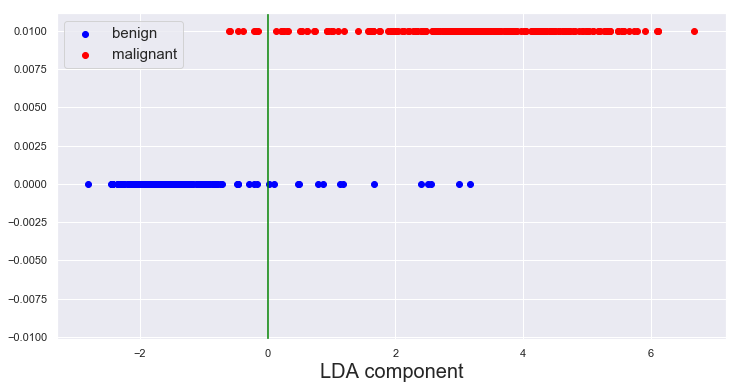

In [876]:
""" Plotting the reduced representation of the benign and malignant tumors """

plt.figure(figsize=(12,6))
plt.scatter(benign,[0 for i in range(len(benign))],color='blue',label='benign')
plt.scatter(malignant,[0.01 for i in range(len(malignant))],color='red',label='malignant')
plt.xlabel('LDA component',fontsize=20)
plt.axvline(0,color='green')
plt.legend(fontsize=15)
plt.show()

In [436]:
""" Training a PCA over the training dataset. 
Note that the actual PCA in the final analysis later has 8 components. 
The initial PCA here has been restricted for visualization purposes"""

pca_plot = PCA(n_components=2)
pca_plot.fit(X_train)
output_pca = pca_plot.transform(scaled_dataset)

In [437]:
""" The explained variance ratio of about 74% for 2 components """

print(pca_plot.explained_variance_ratio_)

[0.66490698 0.08824548]


In [438]:
""" Separating the components for benign and malignant tumors """

benign_pca = []
malignant_pca = []

for index, number in enumerate(output_pca):
    if target[index] == 0:
        benign_pca.append(output_pca[index])
    else:
        malignant_pca.append(output_pca[index])

In [439]:
benign_pca = np.array(benign_pca) # Converting to arrays for easy separation of data
malignant_pca = np.array(malignant_pca)

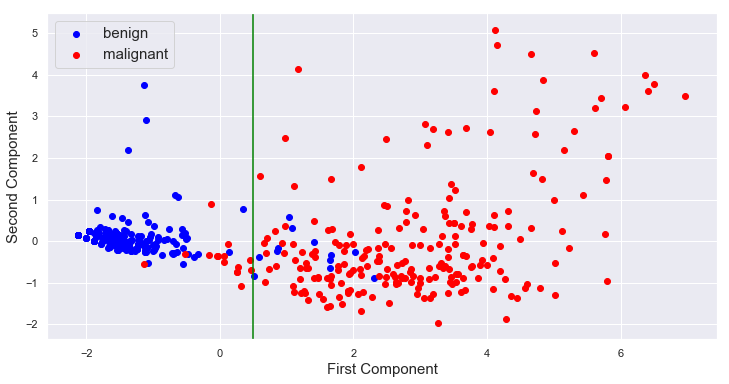

In [878]:
""" Plotting the reduced representation of the benign and malignant tumors """

plt.figure(figsize=(12,6))
plt.scatter(benign_pca[:,0],benign_pca[:,1],color='blue',label='benign')
plt.scatter(malignant_pca[:,0], malignant_pca[:,1],color='red',label='malignant')
plt.axvline(0.5,color='green')
plt.xlabel('First Component',fontsize=15)
plt.ylabel('Second Component',fontsize=15)
plt.legend(fontsize=15)
plt.show()

# Manual Tuning of 2 Main Algorithms

### Random Forest

In [518]:
""" This section conducts the tuning of the Random Forest algorithm over the number of estimators """

randomforest_fn = [] # Collecting the false negatives

for i in range(1,200):
    false_negatives = [] # Internal list for each round of simulation
    
    for _ in range(500): # 500 iterations
        X_train, X_test, y_train, y_test = train_test_split(scaled_dataset,
                                                        target, test_size= 0.5, stratify=target)
        
        model = RandomForestClassifier(n_estimators=i, max_depth=5, criterion='entropy')
        model.fit(X_train, y_train) # Training the classifier for given number of estimators
        
        prediction = model.predict(X_test)
        matrix = confusion_matrix(y_test, prediction)
    
        false_negatives.append(matrix[1][0]) # false negatives
    
    randomforest_fn.append(false_negatives) # Collecting simulation results
    
randomforest_fn_means  = [np.mean(numbers) for numbers in randomforest_fn] # calculating the means

In [519]:
randomforest_fn_upper  = [np.percentile(numbers,97.5) for numbers in randomforest_fn] # upper bounds
randomforest_fn_lower  = [np.percentile(numbers,2.5) for numbers in randomforest_fn] # lower bounds

In [554]:
# Minima of the number of estimators
print(randomforest_fn_means.index(min(randomforest_fn_means)) + 1)

108


In [555]:
# Minima of false negatives 
print(min(randomforest_fn_means))

3.364


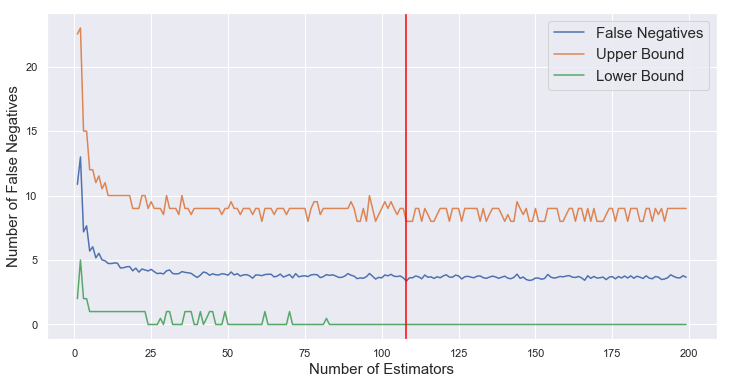

In [880]:
# Plotting the variation of false negatives over the number of estimators

plt.figure(figsize=(12,6))
plt.plot(range(1,200),randomforest_fn_means,label='False Negatives')
plt.plot(range(1,200),randomforest_fn_upper,label='Upper Bound')
plt.plot(range(1,200),randomforest_fn_lower,label='Lower Bound')
plt.axvline(108,color='red')
plt.legend(fontsize=15)
plt.xlabel('Number of Estimators',fontsize=15)
plt.ylabel('Number of False Negatives',fontsize=15)
plt.show()

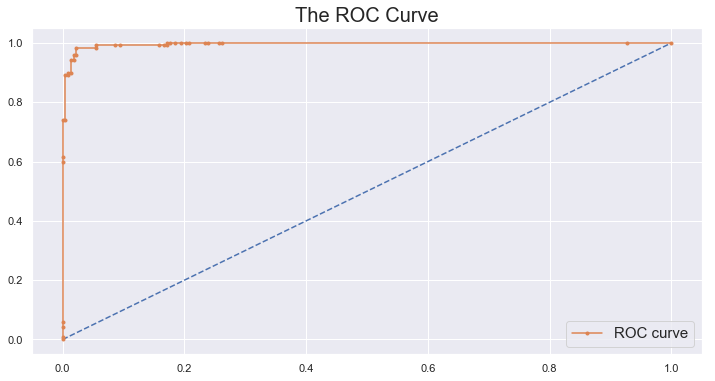

In [929]:
X_train, X_test, y_train, y_test = train_test_split(scaled_dataset,
                                                        target, test_size= 0.5, stratify=target)

random_forest = RandomForestClassifier(n_estimators=108, max_depth=5, criterion='entropy',oob_score=True)
random_forest.fit(X_train, y_train)
probabilities = random_forest.predict_proba(X_test)[:,1]
auc = roc_auc_score(y_test, probabilities)
fpr, tpr, thresholds = roc_curve(y_test, probabilities)
plt.figure(figsize=(12,6))
plt.title('The ROC Curve',fontsize=20)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.',label='ROC curve')
plt.legend(fontsize=15)
plt.show()

In [905]:
print(auc)

0.9920795795795796


In [901]:
prediction = random_forest.predict(X_test)
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

         0.0       0.97      0.96      0.97       222
         1.0       0.93      0.95      0.94       120

   micro avg       0.96      0.96      0.96       342
   macro avg       0.95      0.96      0.96       342
weighted avg       0.96      0.96      0.96       342



In [906]:
print(random_forest.oob_score_ )

0.9706744868035191


In [931]:
print(random_forest.score(X_test,y_test))

0.9707602339181286


In [916]:
print(random_forest.estimators_[:5])

[DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=5,
            max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False,
            random_state=904682768, splitter='best'), DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=5,
            max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False,
            random_state=1608159413, splitter='best'), DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=5,
            max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_lea

 ### SVC

False Negatives for linear:Mean: 5.422 , Confidence Interval: (1.0, 11.0) 
False Positives for linear:Mean: 6.052 , Confidence Interval: (2.0, 10.0) 


False Negatives for poly:Mean: 16.154 , Confidence Interval: (9.0, 24.0) 
False Positives for poly:Mean: 3.112 , Confidence Interval: (1.0, 6.0) 


False Negatives for rbf:Mean: 3.564 , Confidence Interval: (1.0, 8.0) 
False Positives for rbf:Mean: 7.836 , Confidence Interval: (3.48, 12.0) 




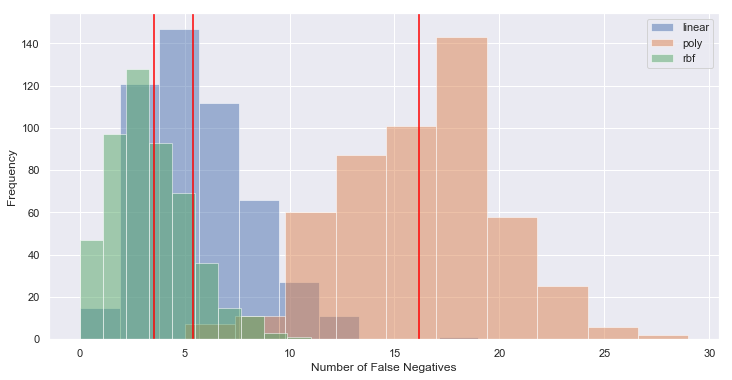

In [861]:
""" This section conducts the tuning of the SVC over different kernels."""

plt.figure(figsize=(12,6))
i = 1

for kernel in ['linear','poly','rbf']:
    
    false_negatives = []
    false_positives = []
    
    for _ in range(500): # 500 MC iterations
        X_train, X_test, y_train, y_test = train_test_split(scaled_dataset,
                                                        target, test_size= 0.5, stratify=target)
    
        if kernel == 'poly': # setting the degree (manually tuned degree)
            model = SVC(kernel=kernel,degree=3,gamma='auto')
        else:
            model = SVC(kernel=kernel,gamma='auto')
        
        model.fit(X_train, y_train) # fitting the mode
        prediction = model.predict(X_test)
        matrix = confusion_matrix(y_test, prediction)
        
        false_positives.append(matrix[0][1]) # Number of false positives
        false_negatives.append(matrix[1][0]) # and false negatives
        
    # Plotting the false negatives as histograms
    plt.hist(false_negatives,alpha=0.5,label=kernel,bins=10)
    plt.axvline(np.mean(false_negatives),color='red')
    
    # Printing the numbers for each kernel along with confidence intervals 
    
    print('False Negatives for ' + str(kernel) + ':' + 'Mean: {}'.format(round(np.mean(false_negatives),3)) +
           ' , ' + 'Confidence Interval: {} '.format((round(np.percentile(false_negatives,2.5),2), 
                                       round(np.percentile(false_negatives,97.5),2))))
    
    print('False Positives for ' + str(kernel) + ':' + 'Mean: {}'.format(round(np.mean(false_positives),3))  + 
         ' , ' + 'Confidence Interval: {} '.format((round(np.percentile(false_positives,2.5),2), 
                                       round(np.percentile(false_positives,97.5),2))))
    print('\n')
    
    i+= 1

plt.legend()
plt.xlabel('Number of False Negatives')
plt.ylabel('Frequency')
plt.show()

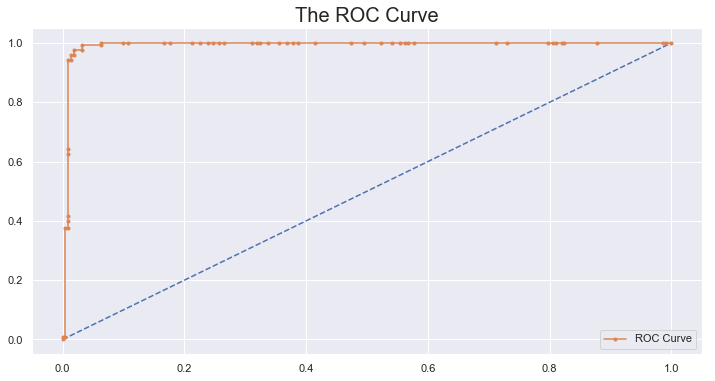

In [895]:
svc_rbf = SVC(kernel='rbf',gamma='auto', probability=True)
svc_rbf.fit(X_train, y_train)
probabilities = svc_rbf.predict_proba(X_test)[:,1]
auc = roc_auc_score(y_test, probabilities)
fpr, tpr, thresholds = roc_curve(y_test, probabilities)
plt.figure(figsize=(12,6))
plt.title('The ROC Curve',fontsize=20)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.',label='ROC Curve')
plt.legend()
plt.show()

In [892]:
print(auc)

0.9916666666666667


In [902]:
prediction = svc_rbf.predict(X_test)
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

         0.0       0.99      0.96      0.97       222
         1.0       0.94      0.97      0.96       120

   micro avg       0.97      0.97      0.97       342
   macro avg       0.96      0.97      0.97       342
weighted avg       0.97      0.97      0.97       342



In [920]:
print(svc_rbf.n_support_)

[19 45]


In [922]:
print(svc_rbf.fit_status_)

0


# Comparing Different Algorithms with PCA and LDA

In [467]:
""" This model utility function is very helpful in the following ways: 
        1. It helps to run a simulation for the given model. 
        2. It can be used to add PCA or LDA to the pipeline. 
        3. It returns the test score and the confusion matrix of the test predictions. """

def model_utility(model,scaled_dataset,target, test_size, pca_conversion = False, lda_conversion=False):
    
    X_train, X_test, y_train, y_test = train_test_split(scaled_dataset,
                                                        target, test_size=test_size, stratify=target)
    
    steps = []
    if pca_conversion: # if specified, we add PCA
        steps.append(('pca',PCA()))
    
    if lda_conversion: # if specified, we add LDA
        steps.append(('lda',LinearDiscriminantAnalysis()))
        
    steps.append(('model',model))
    
    pipeline = Pipeline(steps) # Building the pipeline with the model
    pipeline.fit(X_train, y_train)

    test_score = pipeline.score(X_test, y_test) # test score
    prediction = pipeline.predict(X_test)
    matrix = confusion_matrix(y_test,prediction)# confusion matrix on test predictions
    
    return test_score, matrix

In [828]:
# Building a set of the optimized models and model names to iterate on

model1 = RandomForestClassifier(n_estimators= 108, max_depth=5, criterion='entropy')
model2 = SVC(kernel='rbf',gamma='auto', probability=True)

models = [model1,model2]
model_names = ['Random Forest','SVC with RBF Kernel']

## Cross Validation and Feature Importances

In [829]:
for index, model in enumerate(models):
    scores = cross_val_score(model,scaled_dataset, target, cv=10)
    print(model_names[index], min(scores),np.mean(scores),max(scores))

Random Forest 0.9420289855072463 0.9708220406916823 0.9855072463768116
SVC with RBF Kernel 0.927536231884058 0.9693940782023386 1.0


In [804]:
X_train, X_test, y_train, y_test = train_test_split(scaled_dataset,
                                                        target, test_size=0.5, stratify=target)

pca = PCA()
X_train = pca.fit_transform(X_train)
model_test = models[0]
model_test.fit(X_train, y_train)

print(model_test.feature_importances_)

[0.45063216 0.23401962 0.03572879 0.0563091  0.08238087 0.08609807
 0.0241097  0.03072167]


In [925]:
dataset = pd.DataFrame(scaled_dataset, index = range(len(scaled_dataset)), columns=['Radius', 'Tecture', \
                                    'Perimeter', 'Area','Smoothness','Compactness','Concave Points','Symmetry'])
dataset['target class'] = pd.Series(target,index = range(len(scaled_dataset)))

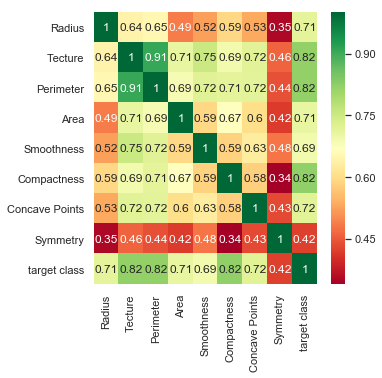

In [926]:
correlation_matrix = dataset.corr()
features = correlation_matrix.index

plt.figure(figsize=(5,5))
g=sns.heatmap(dataset[features].corr(),annot=True,cmap="RdYlGn")

# Simulations

In [534]:
""" This section runs 500 MC simulations on each model and stores the scores 
along the with the number of false negatives and false positives. """

final_scores = []
final_false_numbers = []

for model in models:
    scores = []
    false_numbers = []
    
    for _ in range(500): # 500 MC iterations
        
        test_score, matrix = model_utility(model,scaled_dataset,target, test_size=0.5)
        
        false_positive = matrix[0][1] # extracting the number of false positives
        false_negative = matrix[1][0] # and false negatives
        
        scores.append(test_score)
        false_numbers.append([false_positive,false_negative])
        
    scores = np.array(scores)
    false_numbers = np.array(false_numbers)
    
    final_scores.append(round(np.mean(scores),2)) # Calculating means and recording them
    final_false_numbers.append([np.mean(false_numbers[:,0]),np.mean(false_numbers[:,1])])

### Testing with PCA

In [535]:
""" This section runs the same procedure as above, but with PCA in the pipeline as well."""

final_scores2 = []
final_false_numbers2 = []

for model in models:
    scores = []
    false_numbers = []
    
    for _ in range(500):
        test_score, matrix = model_utility(model,scaled_dataset,target, test_size=0.5, pca_conversion=True)
        false_positive = matrix[0][1]
        false_negative = matrix[1][0]
        
        scores.append(test_score)
        false_numbers.append([false_positive,false_negative])
        
    scores = np.array(scores)
    false_numbers = np.array(false_numbers)
    
    final_scores2.append(round(np.mean(scores),2))
    final_false_numbers2.append([np.mean(false_numbers[:,0]),np.mean(false_numbers[:,1])])

### LDA Conversion

In [536]:
""" This section runs the same procedure as above, but with LDA in the pipeline as well."""

final_scores3 = []
final_false_numbers3 = []

for model in models:
    scores = []
    false_numbers = []
    
    for _ in range(500):
        test_score, matrix = model_utility(model,scaled_dataset,target, test_size=0.5, lda_conversion=True)
        false_positive = matrix[0][1]
        false_negative = matrix[1][0]
        
        scores.append(test_score)
        false_numbers.append([false_positive,false_negative])
        
    scores = np.array(scores)
    false_numbers = np.array(false_numbers)
    
    final_scores3.append(round(np.mean(scores),2))
    final_false_numbers3.append([np.mean(false_numbers[:,0]),np.mean(false_numbers[:,1])])

### Final Scores

In [537]:
# Converting all lists to arrays for easy data extraction and processing

final_scores = np.array(final_scores)
final_scores2 = np.array(final_scores2)
final_scores3 = np.array(final_scores3)

final_false_numbers = np.array(final_false_numbers)
final_false_numbers2 = np.array(final_false_numbers2)
final_false_numbers3 = np.array(final_false_numbers3)

In [830]:
# Tabulating the scores over the original models, PCA and LDA supported models

table = go.Table(
header=dict(values=['Model','Test Scores - Original','Test Scores - PCA','Test Scores - LDA']),
cells =dict(values=[model_names,final_scores[:2],final_scores2[:2],final_scores3[:2]]))

final = [table]
layout = dict(width=900, height=600)
figure = dict(data=final, layout=layout)

py.iplot(figure, filename = 'Final Table - scores')

/usr/local/lib/python3.7/site-packages/IPython/core/display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



In [831]:
# Tabulating the number of false negatives over the original models, PCA and LDA supported models

table = go.Table(
header=dict(values=['Model','False Negatives - Original','False Negatives - PCA','False Negatives - LDA']),
cells=dict(values=[model_names,final_false_numbers[:,1][:2],final_false_numbers2[:,1][:2],final_false_numbers3[:,1][:2]]))

final = [table]
layout = dict(width=900, height=600)
figure = dict(data=final, layout=layout)

py.iplot(figure, filename = 'Final Table - false negatives')

In [832]:
# Tabulating the number of false positives over the original models, PCA and LDA supported models

table = go.Table(
header=dict(values=['Model','False Positives - Original','False Positives - PCA','False Positives - LDA']),
cells=dict(values=[model_names,final_false_numbers[:,0][:2],final_false_numbers2[:,0][:2],final_false_numbers3[:,0][:2]]))

final = [table]
layout = dict(width=900, height=600)
figure = dict(data=final, layout=layout)

py.iplot(figure, filename = 'Final Table - false positives')

# Probability Analysis

In [717]:
""" This section takes the model and training/test datasets as inputs, and then 
visualizes the probabilities for the test dataset by segmenting them into four classes: 
Predicted benign, predicted malignant, False negatives, False positives """

def visualize_probabilities(model, X_train, X_test, y_train, y_test, pca_conversion = True):
    
    if pca_conversion:
        pca = PCA()
        X_train = pca.fit_transform(X_train)
        X_test = pca.transform(X_test)
    
    model.fit(X_train, y_train)
    
    test_probabilities = model.predict_proba(X_test)[:,1]
    prediction = model.predict(X_test)
    
    fp_probs = [] # Lists for collecting all the probabilities
    fn_probs = []
    benign_probs = []
    malignant_probs = []
    
    for i in range(len(y_test)):
        
        # Identifying the kind of data point
    
        false_positive = True if prediction[i] == 1 and y_test[i] == 0 else False
        false_negative = True if prediction[i] == 0 and y_test[i] == 1 else False
        
        # Based on the prediction, we add the probability to the respective list
    
        if false_positive:
            fp_probs.append(test_probabilities[i])
        
        if false_negative:
            fn_probs.append(test_probabilities[i])
    
        if prediction[i] == 0 and y_test[i] == 0:
            benign_probs.append(test_probabilities[i])
    
        elif prediction[i] == 1 and y_test[i] == 1:
            malignant_probs.append(test_probabilities[i])
    
    # Produce combined scatter plot of all the probabilities to observe the overall variation
    
    plt.scatter(malignant_probs,[+0.01 for i in range(len(malignant_probs))],color='green', label='Malignant')
    plt.scatter(benign_probs,[-0.01 for i in range(len(benign_probs))],color='blue', label='Benign')
    plt.scatter(fp_probs,[0 for i in range(len(fp_probs))],color='red', label='False Positives')
    plt.scatter(fn_probs,[0 for i in range(len(fn_probs))],color='maroon', label='False Negatives')

    plt.axvline(0.5,color='red')

Evaluating effect of PCA on the test probabilities

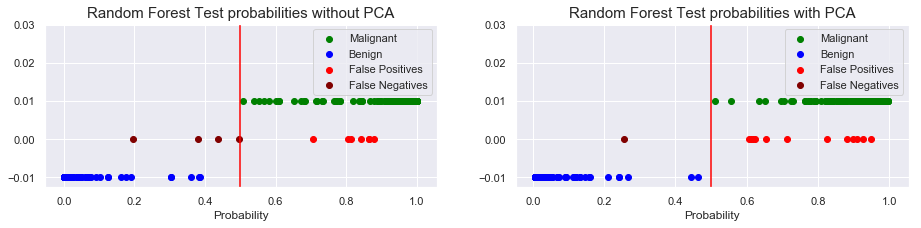

In [866]:
# Using the above function to visualize the probabilities for a single iteration
# of the algorithm with and without PCA

X_train, X_test, y_train, y_test = train_test_split(scaled_dataset,
                                                        target, test_size=0.5, stratify=target)

fig = plt.figure(figsize=(12,5)) 
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.2, wspace=0.2)

i = 0

for pca_conversion in [False, True]: # Without and with PCA
    
    fig.add_subplot(2, 2, i + 1);
    
    # Our best model so far
    model = RandomForestClassifier(n_estimators= 108, max_depth=5, criterion='entropy')
    
    # Visualizing test probabiltiies for given model and data
    visualize_probabilities(model,X_train, X_test, y_train, y_test,pca_conversion)
    
    conversion = 'with PCA' if pca_conversion else 'without PCA'
    
    plt.title('Random Forest Test probabilities ' + conversion,fontsize=15)
    plt.xlabel('Probability')
    plt.legend()
    i += 1
    
plt.show()

Observing test probabilities across all the 2 classifiers

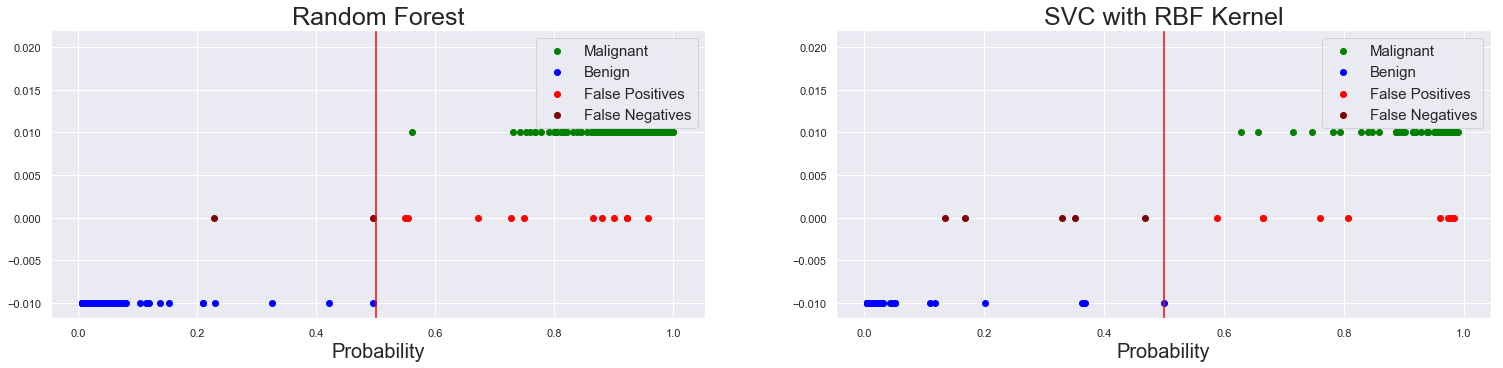

In [869]:
# Using the above function to visualize the probabilities for a single iteration of all 2 classifiers

fig = plt.figure(figsize=(20,4)) 
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.2, wspace=0.2)

i = 0

for model in models: # For each model
    fig.add_subplot(1, 2, i + 1);
    
    # visualize the test probabilities
    visualize_probabilities(model,X_train, X_test, y_train, y_test)
    plt.title(model_names[i], fontsize=25)
    plt.legend(fontsize=15)
    plt.xlabel('Probability',fontsize=20)
    i += 1
    
plt.show()

# Automated Image Consultant

In [842]:
# Preparing the data with the PCA again for the image consultant

X_train, X_test, y_train, y_test = train_test_split(scaled_dataset,
                                                        target, test_size=0.5, stratify=target)
pca = PCA()
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

In [843]:
pca.explained_variance_ratio_

array([0.6566154 , 0.08595414, 0.06764043, 0.05696777, 0.04937714,
       0.04039985, 0.03088339, 0.01216188])

In [782]:
""" This section takes the model and training/test datasets as inputs, and then 
uses the training dataset to build the upper/lower boundary of the region where inputs are flagged"""


def new_model(model,X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    
    train_probabilities = model.predict_proba(X_train)[:,1]
    prediction = model.predict(X_train)
    
    fp_probs = [] # List of all the probabilities
    fn_probs = []
    benign_probs = []
    malignant_probs = []
    
    for i in range(len(y_train)): # For each training input
        
        # Identifying the input
    
        false_positive = True if prediction[i] == 1 and y_train[i] == 0 else False
        false_negative = True if prediction[i] == 0 and y_train[i] == 1 else False
        
        # Adding the probability to the right list based on the outcome
        
        if false_positive:
            fp_probs.append(train_probabilities[i])
        
        if false_negative:
            fn_probs.append(train_probabilities[i])
    
        if prediction[i] == 0 and y_train[i] == 0:
            benign_probs.append(train_probabilities[i])
    
        elif prediction[i] == 1 and y_train[i] == 1:
            malignant_probs.append(train_probabilities[i])
    
    lower_boundary = min(fn_probs) # Lower boundary as minima of training false negatives
    upper_boundary = min(malignant_probs) # Upper boundary as minima of malignant probabilities
    
    # Now we use the boundaries to filter the predictions on the test dataset
    
    test_probabilities = model.predict_proba(X_test)[:,1]
    test_prediction  = model.predict(X_test)
    
    malignant_probs = [] # Calculating the test probs
    benign_probs = []
    flagged = []
    
    false_positives = 0 # We will also uncover the number of false positives 
    false_negatives = 0 # and negatives with the new strategy
    
    
    for index, probability in enumerate(test_probabilities):
        
        if probability > upper_boundary: # Above boundary --> malignant
            malignant_probs.append(probability)
            
            if y_test[index] == 0: # if classified wrongly --> false positive
                false_positives += 1
                
        
        elif probability < lower_boundary: # Below boundary --> benign
            benign_probs.append(probability)
            
            if y_test[index] == 1: # If classified wrongly --> False negative
                false_negatives += 1
            
        elif probability >= lower_boundary and probability <= upper_boundary:
            flagged.append(probability) # if in the region, it's flagged
    
    return model, benign_probs, malignant_probs, flagged, false_positives, false_negatives

In [941]:
""" This section takes the outputs of the above function and visualizes them with the boundaries"""

def visualize_probs(benign_probs, malignant_probs, flagged, false_positives, false_negatives):
    
    plt.figure(figsize=(12,6))
    plt.title('False Negatives: {}, '.format(false_negatives) 
              + 'False Positives: {}'.format(false_positives),fontsize=20)
    # Malignant probabilties above
    plt.scatter(malignant_probs,[+0.01 for i in range(len(malignant_probs))],color='green', label='Malignant')
    # Benign probabilities below
    plt.scatter(benign_probs,[-0.01 for i in range(len(benign_probs))],color='blue', label='Benign')
    
    # flagged cases in the middle
    plt.scatter(flagged,[0 for i in range(len(flagged))],color='red', label='Flagged Cases')
    plt.legend(fontsize=15)

    plt.axvline(min(malignant_probs),color='red')
    plt.axvline(min(flagged), color='red')
    plt.xlabel('Probability')
    plt.show()
    

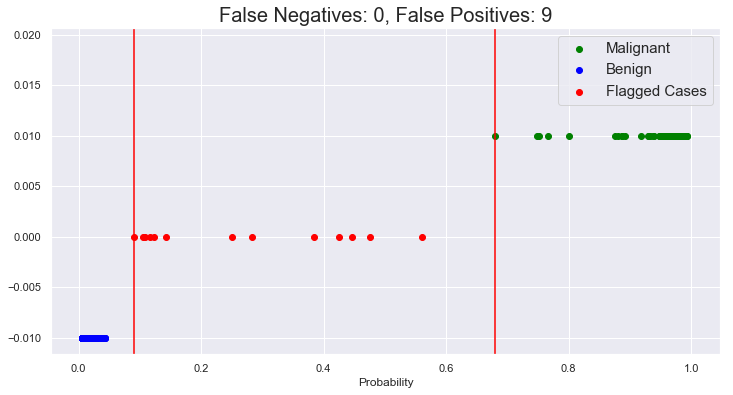

In [963]:
# Visualizing the new classifier's outputs as benign, malignant and the flagged cases
X_train, X_test, y_train, y_test = train_test_split(scaled_dataset,
                                                        target, test_size=0.5, stratify=target)

pca = PCA()
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

final_model, benign_probs, malignant_probs, flagged, false_positives, false_negatives= \
            new_model(models[1],X_train, y_train, X_test, y_test)

visualize_probs(benign_probs, malignant_probs, flagged, false_positives, false_negatives)

# Automated Consultant

In [792]:
""" This section takes a test input, classifies it using the final model and uses the  
boundaries to flag it if necessary"""

def new_classifier(test_input):
    
    probability = final_model.predict_proba([test_input])[0][1]
    prediction = final_model.predict([test_input])[0]
    
    ML_outcome = 'malignant' if prediction == 1 else 'benign'
    
    upper_boundary = min(malignant_probs) # Boundaries as discussed earlier
    lower_boundary = min(flagged)
    
    if probability > upper_boundary: # Malignant
        return 'The test case is malignant tumor.'
                
    elif probability < lower_boundary: # Benign
        return 'The test case is benign tumor.'
     
    else: #Flagged
        return 'The algorithm classified the test case as ' + ML_outcome + \
        ' but it has been flagged and needs manual inspection'

In [793]:
new_classifier(X_test[0]) # Example of benign

'The test case is benign tumor.'

In [794]:
new_classifier(X_test[3]) # Example of malignant

'The test case is malignant tumor.'

In [795]:
# Example of flagged cases

for test_case in X_test:
    result = new_classifier(test_case)
    
    if result != 'The test case is malignant tumor.' and result != 'The test case is benign tumor.':
        print(result)

The algorithm classified the test case as benign but it has been flagged and needs manual inspection
The algorithm classified the test case as benign but it has been flagged and needs manual inspection
The algorithm classified the test case as malignant but it has been flagged and needs manual inspection
The algorithm classified the test case as benign but it has been flagged and needs manual inspection
The algorithm classified the test case as benign but it has been flagged and needs manual inspection
The algorithm classified the test case as benign but it has been flagged and needs manual inspection
The algorithm classified the test case as benign but it has been flagged and needs manual inspection


# Simulations for the new classifier

In [789]:
""" In this section, we simulate the above process of SVC classification and flagging for 500 iterations
and record the number of false negative, and false positives that still exist in the outputs."""

total_fp = []
total_fn = []
total_flagged = []

for _ in range(500): # 500 MC iterations
    X_train, X_test, y_train, y_test = train_test_split(scaled_dataset,
                                                        target, test_size=0.5, stratify=target)
    # Random training and test datasets for each iteration
    
    pca = PCA()
    X_train = pca.fit_transform(X_train)
    X_test = pca.transform(X_test)
    
    try: # Outputs of the new model
        final_model, benign_probs, malignant_probs, flagged, false_positives, false_negatives= \
                                                    new_model(models[1],X_train, y_train, X_test, y_test)
        # Collecting the numbers
        total_fp.append(false_positives)
        total_fn.append(false_negatives)
        total_flagged.append(len(flagged))
        
    except:
        # It may happen that the SVC overfits on the training dataset and gives 100% accuracy. 
        # We skip those parts
        continue

In [790]:
# Printing the mean and confidence intervals of the number of false positives, 
# the number of false negative and the total number of flagged cases.

print('Mean False Positives: {}, '.format(np.mean(total_fp)) + \
      'CI: {}'.format((np.percentile(total_fp,2.5),np.percentile(total_fp,97.5))))

print('Mean False Negatives: {}, '.format(np.mean(total_fn)) + \
      'CI: {}'.format((np.percentile(total_fn,2.5),np.percentile(total_fn,97.5))))

print('Mean Flagged Cases: {}, '.format(np.mean(total_flagged)) + \
      'CI: {}'.format((np.percentile(total_flagged,2.5),np.percentile(total_flagged,97.5))))

Mean False Positives: 6.2439024390243905, CI: (2.0, 11.0)
Mean False Negatives: 1.1056910569105691, CI: (0.0, 4.0)
Mean Flagged Cases: 10.404471544715447, CI: (2.0, 24.0)
